<a href="https://colab.research.google.com/github/ykitaguchi77/PCAF_AI_Project/blob/main/Regression_PCscar_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.optim as optim
import torchvision.models as models
import torch
import torch.nn as nn
#import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
# zip fileを解凍。/content/imagesへ。

import zipfile
zip_parent_path = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Cropped_images"
zip_name = ["Patient_1_Cropped.zip", "Patient13R_Cropped.zip"]
extract_path = "/content/images"

for zip_file in zip_name:
  zip_file_path = os.path.join(zip_parent_path, zip_file)
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully extracted {zip_file} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: {zip_file} not found at {zip_file_path}")
  except zipfile.BadZipFile:
    print(f"Error: {zip_file} is not a valid zip file.")
  except Exception as e:
    print(f"An unexpected error occurred while extracting {zip_file}: {e}")


Successfully extracted Patient_1_Cropped.zip to /content/images
Successfully extracted Patient13R_Cropped.zip to /content/images


In [ ]:
csv_path = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Cropped_images/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv"
cropped_img_dir = "/content/images/Patient_1_Cropped"
first_characters = "pt1_2_0M"

df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

filtered_df.head()

,Track Number,File Prefix1,File Prefix2,Pixels Prefix1,Pixels Prefix2,Ratio
0,1,pt1_2_0M_Photo_label0_track1.png,pt1_4_2Y_Photo_label0_track1.png,918,1020,1.111111
1,2,pt1_2_0M_Photo_label0_track2.png,pt1_4_2Y_Photo_label0_track2.png,957,810,0.846395
2,3,pt1_2_0M_Photo_label0_track3.png,pt1_4_2Y_Photo_label0_track3.png,837,864,1.032258
3,4,pt1_2_0M_Photo_label0_track4.png,pt1_4_2Y_Photo_label0_track4.png,1189,864,0.726661
4,5,pt1_2_0M_Photo_label0_track5.png,pt1_4_2Y_Photo_label0_track5.png,728,506,0.695055


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


TRAIN_dataset_size：798
VAL_dataset_size：199
TEST_dataset_size：199


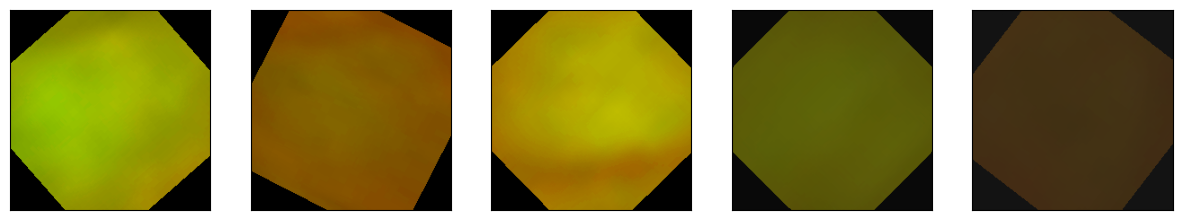

In [ ]:
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.ratio = []

        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]])
        return tensor_image, target

# param
PX = 224 #画像のサイズ
BATCH_SIZE = 16
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.4
TRAIN_CONTRAST_PARAM = 0.7
TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 90
TRAIN_HUE_PARAM = 0.015
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM, saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
                transforms.ToTensor(),
                #transforms.Normalize(*TRAIN_NORMALIZE_PARAM)
                ])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                #transforms.Normalize(*VAL_NORMALIZE_PARAM)
                ])

train_df = filtered_df.sample(frac=0.8, random_state=42)
val_df = filtered_df.drop(train_df.index)

train_dataset = SimpleImageDataset(cropped_img_dir, train_df, train_data_transforms)
val_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)
test_dataset = SimpleImageDataset(cropped_img_dir, val_df, train_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)


print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(test_dataset)))



#水増し後の画像を可視化する関数
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.imshow(image)


#画像の可視化
show_img(train_dataset)



In [ ]:
class LaserSpotResNet(nn.Module):
   def __init__(self):
       super().__init__()
       # ResNet18をベースに転移学習
       self.resnet = models.resnet18(pretrained=True)
       # 入力層を64x64x3に対応
       self.resnet.conv1 = nn.Conv2d(3, 64, 7, stride=1, padding=3)
       self.resnet.maxpool = nn.MaxPool2d(2, stride=2)
       # 回帰のための出力層
       self.resnet.fc = nn.Sequential(
           nn.Linear(512, 128),
           nn.ReLU(),
           nn.Dropout(0.5),
           nn.Linear(128, 1)
       )

   def forward(self, x):
       return self.resnet(x)

# モデル定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LaserSpotResNet().to(device)

# 学習設定
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer,
   mode='min',
   factor=0.1,
   patience=5,
   verbose=True
)



#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# # Early Stopping
# class EarlyStopping:
#    def __init__(self, patience=10, min_delta=0):
#        self.patience = patience
#        self.min_delta = min_delta
#        self.counter = 0
#        self.best_loss = None
#        self.early_stop = False

#    def __call__(self, val_loss):
#        if self.best_loss is None:
#            self.best_loss = val_loss
#        elif val_loss > self.best_loss - self.min_delta:
#            self.counter += 1
#            if self.counter >= self.patience:
#                self.early_stop = True
#        else:
#            self.best_loss = val_loss
#            self.counter = 0

# early_stopping = EarlyStopping(patience=10)
# epochs = 100

#**Modules**

In [ ]:
####################################
####################################
#Test with early-stopping
####################################
####################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################
        # validate the model #
        ######################

        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses





RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identi

<ipython-input-7-71a0f4defb03>:481: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-B3-200epoc

#**Train model & save network**

Epoch: [  1/100] 
train_loss: 0.09192 
valid_loss: 0.01628 
Validation loss decreased (inf --> 0.016281).  Saving model ...

Epoch: [  2/100] 
train_loss: 0.01897 
valid_loss: 0.01988 
EarlyStopping counter: 1 out of 20

Epoch: [  3/100] 
train_loss: 0.02385 
valid_loss: 0.00788 
Validation loss decreased (0.016281 --> 0.007879).  Saving model ...

Epoch: [  4/100] 
train_loss: 0.00967 
valid_loss: 0.00557 
Validation loss decreased (0.007879 --> 0.005566).  Saving model ...

Epoch: [  5/100] 
train_loss: 0.00967 
valid_loss: 0.00918 
EarlyStopping counter: 1 out of 20

Epoch: [  6/100] 
train_loss: 0.00940 
valid_loss: 0.00550 
Validation loss decreased (0.005566 --> 0.005500).  Saving model ...

Epoch: [  7/100] 
train_loss: 0.00866 
valid_loss: 0.00617 
EarlyStopping counter: 1 out of 20

Epoch: [  8/100] 
train_loss: 0.00606 
valid_loss: 0.00827 
EarlyStopping counter: 2 out of 20

Epoch: [  9/100] 
train_loss: 0.00622 
valid_loss: 0.00823 
EarlyStopping counter: 3 out of 20

Epoch

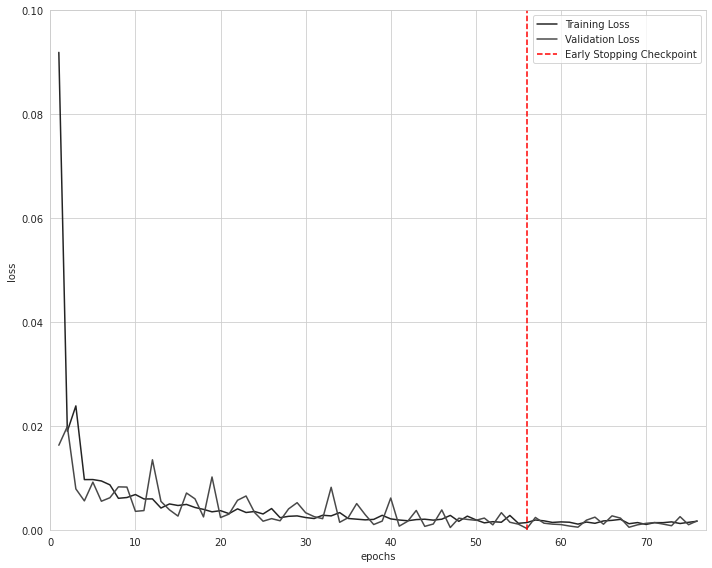

In [ ]:
model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)

#ネットワークの保存
PATH = MODEL_PATH+'/'+MODEL_NAME+'.pth'
torch.save(model_ft.state_dict(), PATH)

# Drawing learning curves
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')


#**Evaluation using testset**

In [ ]:
PATH = MODEL_PATH+'/'+MODEL_NAME+'.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#**Result analysis**

In [ ]:
import statistics

def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)

      outputs.append((output[0]*100).item())
      targets.append((target[0]*100).item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append((output[0]*100).item()-(target[0]*100).item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


#csvを作成して保存
columns = ["result"]
index = ["AveError", "StdError", "AveAbsError", "StdAbsError", "Corrected_AveAbsError", "Corrected_StdAbsError"]
df = pd.DataFrame(index=index, columns=columns)
df.iloc[0:6, 0] =[statistics.mean(errors),statistics.stdev(errors),statistics.mean(AbsError),statistics.stdev(AbsError), statistics.mean(corrected_AbsError),statistics.stdev(corrected_AbsError)]
print(df)

PATH = MODEL_PATH+'/'+MODEL_NAME+'.csv'
df.to_csv(index=True, path_or_buf=PATH)

AveError: -0.6522686870385569
StdError: 6.815834914951809
AveAbsError: 5.244466970998345
StdAbsError: 4.390929257395176
Corrected_AveAbsError: 5.249798833865178
Corrected_StdAbsError: 4.335566643467942
                         result
AveError              -0.652269
StdError               6.815835
AveAbsError            5.244467
StdAbsError            4.390929
Corrected_AveAbsError  5.249799
Corrected_StdAbsError  4.335567


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

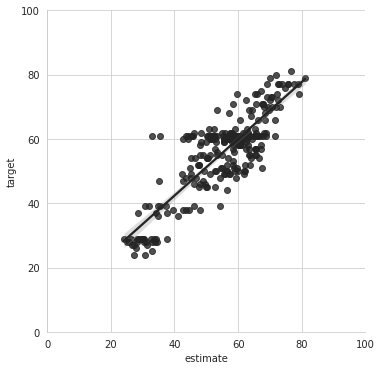

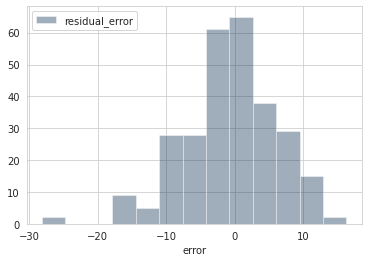

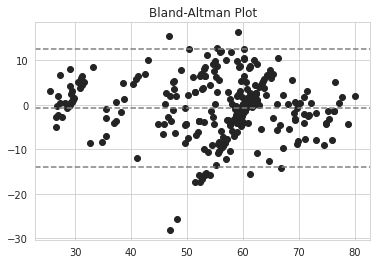

In [ ]:
import seaborn as sns

#Draw Graphs（散布図)
df = pd.DataFrame({'estimate':outputs, 'target':targets})


#Scatterplot
plt.figure()
sns.set_style('whitegrid')
sns.set_palette('gray')
figure = sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(0,100)
plt.ylim(0,100)




PATH = MODEL_PATH+'/'+MODEL_NAME+'.png'
figure.savefig(PATH)



#Draw histogram
plt.figure()

df['error']=""
for i in range(len(df)):
    df.iloc[i,2] = df.iloc[i,0]-df.iloc[i,1]

sns.distplot(
    df['error'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示



#Bland-Altman-Plot
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

#**結果をCSVファイルに記載**

In [ ]:
#result.csv作成（ファイルがなければ）
if os.path.exists(FILENAME_RESULTCSV) == False:
    df_result = df_labelcsv.copy()
else:
    print(FILENAME_RESULTCSV + " already exists!")

df_result = pd.read_csv(FILENAME_RESULTCSV, index_col=0)
print(df_result)


"""
################
#df_resultを初期化
################

df_result = df_labelcsv.copy()
df_result["set"] = "0"  #工程の列を追加

#valフォルダ内のファイル名を取得
train_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")
val_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")
test_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")

for i in train_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "train"
for i in val_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "val"
for i in test_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "test"

print(df_result)
"""

result.csv already exists!
                   filename  age  ... cropped_A2  cropped_A2_pretrained
0     img00085008_00_1R.jpg   61  ...  42.550665              51.511717
1     img00085024_00_1R.jpg   29  ...  39.297953              27.813551
2     img00241280_10_1R.jpg   51  ...  50.525779              57.090443
3     img00265140_00_1R.jpg   29  ...  37.621737              31.148827
4     img00265140_00_2L.jpg   29  ...  45.709464              28.956094
...                     ...  ...  ...        ...                    ...
1409  img76791392_10_1R.jpg   38  ...  27.728298              35.313144
1410  img76843122_10_1R.jpg   49  ...  54.683352              42.622042
1411  img76843122_11_1R.jpg   49  ...  51.311404              44.966671
1412  img76888512_00_1R.jpg   74  ...  55.601197              67.208940
1413  img76888512_00_2L.jpg   74  ...  57.358873              79.072827

[1414 rows x 6 columns]


'\n################\n#df_resultを初期化\n################\n\ndf_result = df_labelcsv.copy()\ndf_result["set"] = "0"  #工程の列を追加\n\n#valフォルダ内のファイル名を取得\ntrain_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")\nval_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")\ntest_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")\n\nfor i in train_data_path:\n    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "train"\nfor i in val_data_path:\n    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "val"\nfor i in test_data_path:\n    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "test"\n\nprint(df_result)\n'

In [ ]:
#Calculating result

#対象のパスからラベルを抜き出して表示
def getlabel(result_csv, image_name):
      image_name = image_name
      label = df_result[df_result.iloc[:,0] == image_name].iloc[0,1] #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得
      return(image_name, label)


#評価のための画像下処理
def image_transform(image_path):
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor()])
    image_tensor = transform(image)


    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


#モデルにした処理した画像を投入して予測結果を出力
def image_eval(image_tensor, model_ft):
    output = model_ft(image_tensor).item()*100
    return output

#result.csvに結果を記入
def write_result(df, image_name, pred, row):
    df.loc[df_result.iloc[:,0] == image_name, row] = pred  #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得




#ここからがメイン
model_ft.eval() # prep model for evaluation

#valフォルダ内のファイル名を取得
train_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")
val_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")
test_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")

data_path = [train_data_path, val_data_path, test_data_path]
k=0
for j in data_path:
    for i in j:
          image_name, label = getlabel(df_result, os.path.basename(i))  #画像の名前とラベルを取得
          image_tensor = image_transform(i)  #予測のための画像下処理
          pred = image_eval(image_tensor, model_ft)  #予測結果を出力
          write_result(df_result, image_name, pred, MODEL_NAME)
          print(str(k)+"/"+str(len(df_result)) + " images processed!")
          k+=1
print(df_result)

0/1414 images processed!
1/1414 images processed!
2/1414 images processed!
3/1414 images processed!
4/1414 images processed!
5/1414 images processed!
6/1414 images processed!
7/1414 images processed!
8/1414 images processed!
9/1414 images processed!
10/1414 images processed!
11/1414 images processed!
12/1414 images processed!
13/1414 images processed!
14/1414 images processed!
15/1414 images processed!
16/1414 images processed!
17/1414 images processed!
18/1414 images processed!
19/1414 images processed!
20/1414 images processed!
21/1414 images processed!
22/1414 images processed!
23/1414 images processed!
24/1414 images processed!
25/1414 images processed!
26/1414 images processed!
27/1414 images processed!
28/1414 images processed!
29/1414 images processed!
30/1414 images processed!
31/1414 images processed!
32/1414 images processed!
33/1414 images processed!
34/1414 images processed!
35/1414 images processed!
36/1414 images processed!
37/1414 images processed!
38/1414 images process

In [ ]:
#Resultファイルを書き出し
df_result.to_csv(FILENAME_RESULTCSV)